In [2]:
import warnings 
warnings.filterwarnings('ignore')

## K-Nearest-Neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

## Overview

1.Read the problem statement.

2.Get the dataset.

3.Explore the dataset.

4.Pre-processing of dataset.

5.Visualization

6.Transform the dataset for building machine learning model.

7.Split data into train, test set.

7.Build Model.

8.Apply the model.

9.Evaluate the model.

10.Finding Optimal K value

11.Repeat 7,8,9 steps.

## Problem statement

### Dataset

The data set we’ll be using is the Iris Flower Dataset which was first introduced in 1936 by the famous statistician Ronald Fisher and consists of 50 observations from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals.

**Attributes of the dataset:** https://archive.ics.uci.edu/ml/datasets/Iris

**Train the KNN algorithm to be able to distinguish the species from one another given the measurements of the 4 features.**

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore


In [4]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold

In [5]:
# importing ploting libraries
import matplotlib.pyplot as plt   
#importing seaborn for statistical plots
import seaborn as sns
# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

## Question 1

Import the data set and print 10 random rows from the data set

In [6]:
# Since it is a data file with no header, we will supply the column names which have been obtained from the above URL 
# Create a python list of column names called "names"

colnames = ['sepal_Length', 'sepal_Width', 'petal_Length', 'petal_Width', 'species']

iris_df = pd.read_csv("iris.data", names= colnames)

In [7]:
#Get Iris Data Frame Shape
iris_df.shape

(150, 5)

In [8]:
#Get Iris Data Frame Info
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_Length    150 non-null float64
sepal_Width     150 non-null float64
petal_Length    150 non-null float64
petal_Width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [9]:
#Print Random 10 row
iris_df.sample(n=10)

,sepal_Length,sepal_Width,petal_Length,petal_Width,species
53,5.5,2.3,4.0,1.3,Iris-versicolor
92,5.8,2.6,4.0,1.2,Iris-versicolor
9,4.9,3.1,1.5,0.1,Iris-setosa
138,6.0,3.0,4.8,1.8,Iris-virginica
14,5.8,4.0,1.2,0.2,Iris-setosa
76,6.8,2.8,4.8,1.4,Iris-versicolor
74,6.4,2.9,4.3,1.3,Iris-versicolor
111,6.4,2.7,5.3,1.9,Iris-virginica
72,6.3,2.5,4.9,1.5,Iris-versicolor
117,7.7,3.8,6.7,2.2,Iris-virginica


## Data Pre-processing

## Question 2 - Estimating missing values

*Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median) *

In [10]:
#get Describtion of the iris Data
iris_df.describe()

,sepal_Length,sepal_Width,petal_Length,petal_Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [11]:
# mark zero values as missing or NaN
#iris_df[[1,2,3,4,5]] = iris_df[[1,2,3,4,5]].replace(0, numpy.NaN)
# fill missing values with mean column values
iris_df.fillna(iris_df.median(), inplace=True)
# count the number of NaN values in each column
print(iris_df.isnull().sum())

sepal_Length    0
sepal_Width     0
petal_Length    0
petal_Width     0
species         0
dtype: int64


## Question 3 - Dealing with categorical data

Change all the classes to numericals (0to2).

In [12]:
replace_map = {'species': {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}}

iris_df.replace(replace_map, inplace=True)

In [13]:
iris_df["species"].value_counts()

2    50
1    50
0    50
Name: species, dtype: int64

## Question 4

*Observe the association of each independent variable with target variable and drop variables from feature set having correlation in range -0.1 to 0.1 with target variable.*

In [14]:
#Iris Data column correlation
correlation_matrix =iris_df.corr()
#Get Correlation of each independent variable with target variable 
correlation_matrix.loc["species":,]
# As per correlation matrix, there is no feature set having correlation in range -0.1 to 0.1 with target variable (Species)

,sepal_Length,sepal_Width,petal_Length,petal_Width,species
species,0.782561,-0.419446,0.949043,0.956464,1.0


##### As per correlation matrix, there is no feature set having correlation in range -0.1 to 0.1 with target variable (Species)

## Question 5

*Observe the independent variables variance and drop such variables having no variance or almost zero variance(variance < 0.1). They will be having almost no influence on the classification.*

In [83]:
# Get independent variable in X
X = iris_df.drop("species", axis=1)
# Get Target variable in y
y = iris_df["species"]

In [84]:
# instantiate VarianceThreshold object
vt = VarianceThreshold(0.1)   

#Features with a variance lower than 0.1 threshold will be removed
vt.fit_transform(X,y)

# get the indices of the features that are being kept
feature_indices = vt.get_support(indices=True)
feature_indices

array([0, 1, 2, 3], dtype=int64)

In [87]:
X.columns

Index(['sepal_Length', 'sepal_Width', 'petal_Length', 'petal_Width'], dtype='object')

##### As per variance threshold process result, there is no features variance is < 0.1. So,its not removed any columns

## Question 6

*Plot the scatter matrix for all the variables.*

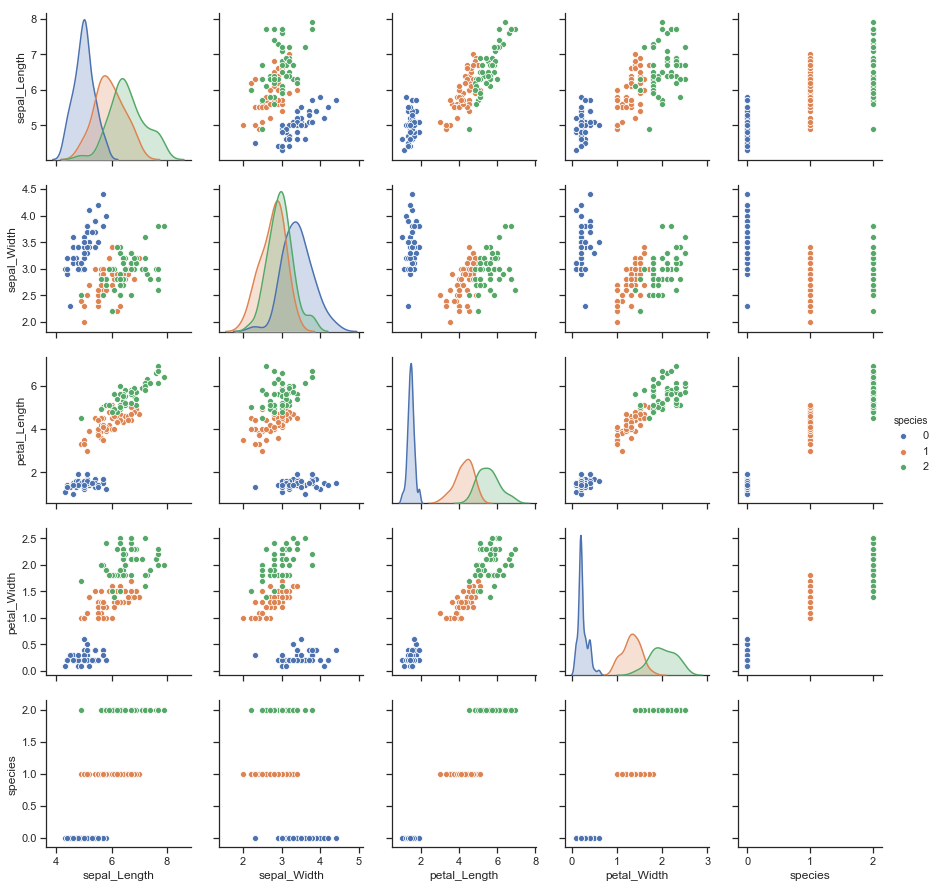

In [17]:
# Pairplot using sns
#sns.pairplot(iris_df)
sns.set(style="ticks")
sns.pairplot(iris_df, hue="species")

## Split the dataset into training and test sets

## Question 7

*Split the dataset into training and test sets with 80-20 ratio.*

In [19]:
test_size = 0.20 # taking 80:20 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [20]:
print("Iris Train Data Shape : {0}".format(X_train.shape))
print("Iris Test Data Shape : {0}".format(X_test.shape))
print("Iris Full Data Shape : {0}".format(X.shape))

Iris Train Data Shape : (120, 4)
Iris Test Data Shape : (30, 4)
Iris Full Data Shape : (150, 4)


## Question 8 - Model

*Build the model and train and test on training and test sets respectively using **scikit-learn**. Print the Accuracy of the model with different values of **k=3,5,9**.*

**Hint:** For accuracy you can check **accuracy_score()** in scikit-learn

In [21]:
def KNeighborsClassifierModelAnalysis(k):
    NNH = KNeighborsClassifier(n_neighbors= k)
    # Call Nearest Neighbour algorithm
    NNH.fit(X_train, y_train)
    trainPreds=NNH.predict(X_train)
    testPreds=NNH.predict(X_test)
    #Get Train Data Accuracy
    trainAccuracy=accuracy_score(y_train,trainPreds)
   
     #Get Test Data Accuracy
    testAccuracy=accuracy_score(y_test,testPreds)
   
    resultsDf = pd.DataFrame( index=["K-Value", "Accuracy"])
    trainResults=[k, trainAccuracy]
    testResults=[k, testAccuracy]
    resultsDf['TrainResults'] = trainResults
    resultsDf['TestResults'] = testResults
    
    return resultsDf.round(2)

In [22]:
k_List=[3,5,9]

for k in k_List:
    resultDf=KNeighborsClassifierModelAnalysis(k)
    print("KNN Model Accuracy When K-Value is {0} :".format(k))
    print(resultDf)
    print()


KNN Model Accuracy When K-Value is 3 :
          TrainResults  TestResults
K-Value           3.00          3.0
Accuracy          0.98          0.9

KNN Model Accuracy When K-Value is 5 :
          TrainResults  TestResults
K-Value           5.00          5.0
Accuracy          0.98          0.9

KNN Model Accuracy When K-Value is 9 :
          TrainResults  TestResults
K-Value           9.00          9.0
Accuracy          0.99          0.9



## Question 9 - Cross Validation

Run the KNN with no of neighbours to be 1,3,5..19 and *Find the **optimal number of neighbours** from the above list using the Mis classification error

Hint:

Misclassification error (MSE) = 1 - Test accuracy score. Calculated MSE for each model with neighbours = 1,3,5...19 and find the model with lowest MSE

In [23]:
# creating odd list of K for KNN (neighbors = 1,3,5,7,... 19)
neighbors = list(range(1,20,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

cv_scores

[0.9725757575757574,
 0.9725757575757574,
 0.9816666666666667,
 0.9725757575757574,
 0.9839743589743589,
 0.9839743589743589,
 0.9916666666666666,
 0.9916666666666666,
 0.9825757575757574,
 0.9916666666666666]

In [24]:
# changing to misclassification error [MSE=1-CV_Scores]
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]

print("Lowest Misclassification Error is {0}.".format(min(MSE)))
print("The optimal number of neighbors is {0}.".format(optimal_k))

Lowest Misclassification Error is 0.008333333333333415.
The optimal number of neighbors is 13.


In [25]:
#Test accuracy with optimal value. Note, optimal value will get it from previous steps
resultDf=KNeighborsClassifierModelAnalysis(13)
print("KNN Model Accuracy When K-Value is {0}  (Optimal Value)".format(optimal_k))
print(resultDf)

# Looks K value 9 & 13 have same accuracy value

KNN Model Accuracy When K-Value is 13  (Optimal Value)
          TrainResults  TestResults
K-Value          13.00         13.0
Accuracy          0.99          0.9


## Question 10

*Plot misclassification error vs k (with k value on X-axis) using matplotlib.*

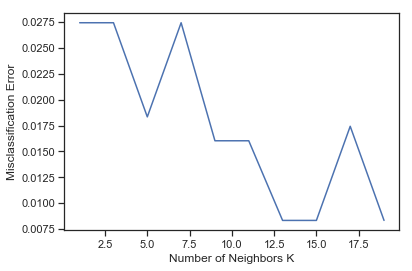

In [26]:
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# Naive Bayes with Iris Data

In [27]:
#Load all required library
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

### Slice  Iris data set for Independent variables and dependent variables
#### Please note 'Species' is my dependent variables, name it y and independent set data as X

In [28]:
#Check the dataset
print(y)
print(X)

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
120    2
121    2
122    2
123    2
124    2
125    2
126    2
127    2
128    2
129    2
130    2
131    2
132    2
133    2
134    2
135    2
136    2
137    2
138    2
139    2
140    2
141    2
142    2
143    2
144    2
145    2
146    2
147    2
148    2
149    2
Name: species, Length: 150, dtype: int64
     sepal_Length  sepal_Width  petal_Length  petal_Width
0             5.1          3.5           1.4          0.2
1             4.9          3.0           1.4          0.2
2             4.7          3.2           1.3          0.2
3             4.6          3.1           1.5          0.2
4             5.0          3.6           1.4          0.2
5             5.4          3.9           1.7          0.4
6   

# Question 11 
Find the distribution of target variable (Class)

And, Plot the distribution of target variable using histogram

In [29]:
iris_df["species"].value_counts()

2    50
1    50
0    50
Name: species, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D12B9E8>]],
      dtype=object)

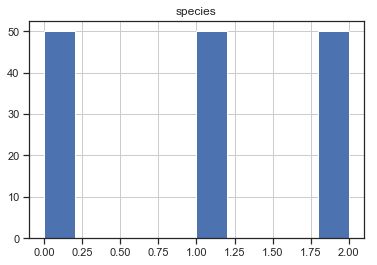

In [30]:
iris_df.hist(column='species')


In [31]:
#Drop Id variable from data

### Question 12 
Find Correlation among all variables and give your insights 

In [32]:
#Please note, it's Require to remove correlated features because they are voted twice in the model and 
## it can lead to over inflating importance.We will ignore it here

[]

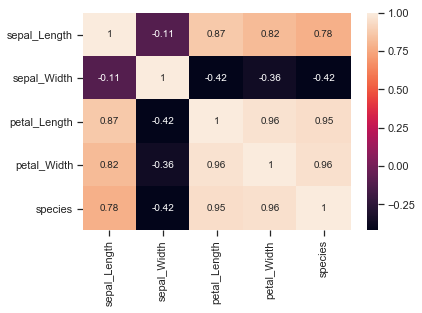

In [33]:
sns.heatmap(iris_df.corr(),annot=True)
plt.plot()

#### 1. Petal Length & Petal Width are slightly correlated (0.96) with each other
#### 2. Petal Length & Species are slightly correlated (0.95) with each other
#### 3. Petal Width & Species are slightly correlated (0.96) with each other

### Split data in Training and test set in 80:20.

### Question 13 
Do Feature Scaling 

In [35]:
# Use StandardScaler or similar methods

from sklearn.preprocessing import StandardScaler

In [36]:
# Standardize data (0 mean, 1 stdev)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Standardize data
X

array([[-9.00681170e-01,  1.03205722e+00, -1.34127240e+00,
        -1.31297673e+00],
       [-1.14301691e+00, -1.24957601e-01, -1.34127240e+00,
        -1.31297673e+00],
       [-1.38535265e+00,  3.37848329e-01, -1.39813811e+00,
        -1.31297673e+00],
       [-1.50652052e+00,  1.06445364e-01, -1.28440670e+00,
        -1.31297673e+00],
       [-1.02184904e+00,  1.26346019e+00, -1.34127240e+00,
        -1.31297673e+00],
       [-5.37177559e-01,  1.95766909e+00, -1.17067529e+00,
        -1.05003079e+00],
       [-1.50652052e+00,  8.00654259e-01, -1.34127240e+00,
        -1.18150376e+00],
       [-1.02184904e+00,  8.00654259e-01, -1.28440670e+00,
        -1.31297673e+00],
       [-1.74885626e+00, -3.56360566e-01, -1.34127240e+00,
        -1.31297673e+00],
       [-1.14301691e+00,  1.06445364e-01, -1.28440670e+00,
        -1.44444970e+00],
       [-5.37177559e-01,  1.49486315e+00, -1.28440670e+00,
        -1.31297673e+00],
       [-1.26418478e+00,  8.00654259e-01, -1.22754100e+00,
      

In [37]:
test_size = 0.20 # taking 80:20 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [38]:
print("Iris Train Data Shape : {0}".format(X_train.shape))
print("Iris Test Data Shape : {0}".format(X_test.shape))
print("Iris Full Data Shape : {0}".format(X.shape))

Iris Train Data Shape : (120, 4)
Iris Test Data Shape : (30, 4)
Iris Full Data Shape : (150, 4)


### Question 14 
Train and Fit NaiveBayes Model

In [39]:
#Fit the model
model = GaussianNB()
model.fit(X_train, y_train)
print(model)

GaussianNB(priors=None, var_smoothing=1e-09)


In [40]:
#Predict
# make predictions
predicted = model.predict(X_test)

### Question 15 
Print Accuracy and Confusion Matrix and Conclude your findings

In [41]:
# show Confusion Matrix

metrics.confusion_matrix(predicted, y_test)

array([[7, 0, 0],
       [0, 9, 2],
       [0, 3, 9]], dtype=int64)

In [42]:
# show accuracy
print("Accuracy : {0}".format(accuracy_score(y_test,predicted)))

Accuracy : 0.8333333333333334


In [43]:
#Show precision and Recall metrics
#recall_score(y_test, predicted,average=None)
cr=metrics.classification_report(y_test,predicted)
print(cr)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.82      0.75      0.78        12
           2       0.75      0.82      0.78        11

   micro avg       0.83      0.83      0.83        30
   macro avg       0.86      0.86      0.86        30
weighted avg       0.84      0.83      0.83        30



# For Practice  - Optional

All the questions from 16 to 20 are for practice.

# Using SVM with Diebetes Dataset

In [44]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Question 16 
Read the input file 'Diabetes.csv' using Pandas and check it's column names.

Check dimension of dataset.

Check distribution of dependent variable, Outcome and plot it.


In [45]:
# Eye ball the imported dataset

### Out of  768 data points, 500 are labeled as 0 and 268 as 1.
### Outcome 0 means No diabetes, outcome 1 means diabetes

In [46]:
# Check data types and info of dataset

# Question 17 
Check data distribution using summary statistics and provide your findings.

Do correlation analysis and bivariate viualization with Insights


# Question 18 
Do train and test split. 
Optionally - You can do with stratify sampling(optional) on Outcome variable to maintain the distribution of dependent variable

# Question 19 
Train Support Vector Machine Model(1 Marks)

In [47]:
# use from sklearn.svm import SVC

In [48]:
# your insights

# Question 20
Scale the data points using MinMaxScaler

Fit SVM Model on Scale data and give your observation

#we can try increasing either C or gamma to fit a more complex model.

# Optional Question - 
Try improving the model accuracy using C=1000 (1 Marks)

### Here, increasing C allows us to improve the model, resulting in ??? accuracy.
### Let's try to explore different Kernel and C (Bonus for practice)

In [49]:
import multiprocessing 
from sklearn.model_selection import GridSearchCV

In [50]:
 param_grid = [    {        
     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],        
     'C': [ 0.1, 0.2, 0.4, 0.5, 1.0, 1.5, 1.8, 2.0, 2.5, 3.0 ]    } ]

In [51]:
gs = GridSearchCV(estimator=SVC(), param_grid=param_grid,scoring='accuracy', cv=10, n_jobs=multiprocessing.cpu_count())

NameError: name 'SVC' is not defined

In [ ]:
gs.fit(X_train_scaled, y_train) 

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_score_ 